# Laboratorium 4: Sieci Neuronowe i Keras/Tensorflow
## Część II. Uczenie ze wzmocnieniem

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

### Ładowanie ResNet

In [2]:
model = tf.keras.applications.ResNet50(weights = 'imagenet')
print(f'Number of layers = {len(model.layers)}')

Number of layers = 177


### Wczytywanie obrazów

In [3]:
import cv2
import os
import sklearn
image_size = tuple((64, 64))

def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            #image = preprocess_input(image)
            image = cv2.resize(image, image_size)
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('flower_photos')
print('loaded',len(samples),' samples')
print('classes',set(labels))

loaded 3670  samples
classes {'daisy', 'tulips', 'dandelion', 'sunflowers', 'roses'}


### Przykładowe obrazy

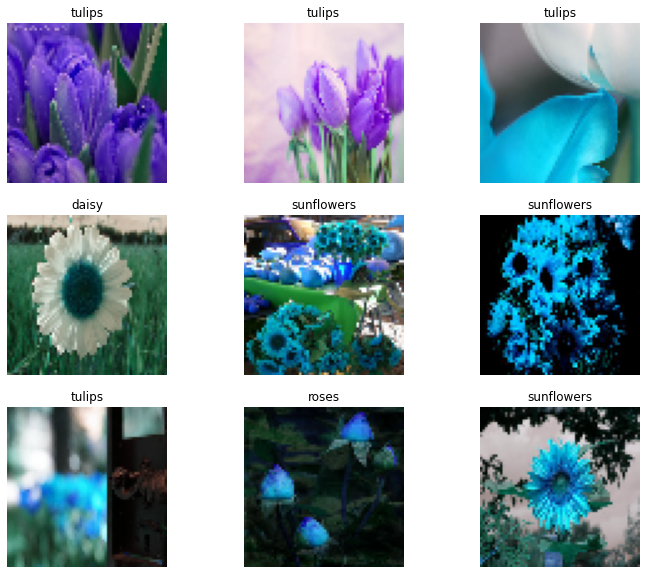

In [4]:
plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    plt.title(labels[n])
    plt.axis("off")

### Przetwarzanie obrazów

In [5]:
org_samples = samples[:]
samples = tf.keras.applications.resnet50.preprocess_input(samples)

### Model bazowy

In [6]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

### Budowa modelu

In [7]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
last_layer = tf.keras.layers.Dense(5, activation = 'softmax')(x)

model = tf.keras.models.Model(inputs = base_model.input, outputs = last_layer)

print(f"Number of layers: {len(model.layers)}")

Number of layers: 181


### Ustawianie atrybutów jako "trenowalnych"

In [8]:
for layer in model.layers[:175]:
    layer.trainable = False
    
for layer in model.layers[175:]:
    layer.trainable = True

### One-Hot

In [9]:
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder() # encoder
intlabels = encoder.fit_transform(labels)
labels = tf.keras.utils.to_categorical(intlabels)
print("One-hot labels",labels.shape)

One-hot labels (3670, 5)


### Trenowanie modelu

In [10]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,test_size=0.2,random_state=42)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

checkpt = ModelCheckpoint (filepath='resnet50_model.h5', save_best_only=True)
estopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

EPOCHS = 10
H = model.fit(trainSamples, trainLabels, epochs=EPOCHS, batch_size=30, validation_data=(testSamples,testLabels),
             callbacks = [estopping,checkpt]) 
print("Trening zakończony")

Epoch 1/10
98/98 [==============================] - 18s 165ms/step - loss: 2.0950 - accuracy: 0.5380 - val_loss: 0.7193 - val_accuracy: 0.7248
Epoch 2/10
98/98 [==============================] - 15s 150ms/step - loss: 0.5178 - accuracy: 0.8298 - val_loss: 0.7740 - val_accuracy: 0.7234
Epoch 3/10
98/98 [==============================] - 15s 151ms/step - loss: 0.3592 - accuracy: 0.8747 - val_loss: 0.9206 - val_accuracy: 0.7153
Epoch 4/10
98/98 [==============================] - 15s 150ms/step - loss: 0.2731 - accuracy: 0.9084 - val_loss: 1.0385 - val_accuracy: 0.7221
Epoch 5/10
98/98 [==============================] - 15s 150ms/step - loss: 0.1971 - accuracy: 0.9316 - val_loss: 1.0900 - val_accuracy: 0.7480
Epoch 6/10
98/98 [==============================] - 15s 150ms/step - loss: 0.1541 - accuracy: 0.9540 - val_loss: 1.1137 - val_accuracy: 0.7330
Epoch 00006: early stopping
Trening zakończony


### Wyniki

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
testResults = model.predict(testSamples)

print(confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print("CNN Accuracy: {:.2f}".format(accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))
print("Cohen's Kappa: {:.2f}".format(cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))

[[129   9   2   1   9]
 [ 15 125   6  15   5]
 [ 17   8  86   3  18]
 [ 15   7   7  93   7]
 [ 16   5  23   8 105]]
              precision    recall  f1-score   support

           0       0.67      0.86      0.75       150
           1       0.81      0.75      0.78       166
           2       0.69      0.65      0.67       132
           3       0.78      0.72      0.75       129
           4       0.73      0.67      0.70       157

    accuracy                           0.73       734
   macro avg       0.74      0.73      0.73       734
weighted avg       0.74      0.73      0.73       734

CNN Accuracy: 0.73
Cohen's Kappa: 0.67
